# Breast MRI QA

This notebook allows a user to obtain MRI studies from an Orthanc DICOM server and apply a range of QA tests. The notebook acts as an interface to the `breast_mri_qa` package. Please read the instructions preceding each code cell, make any neccesary changes, and then execute the code before moving on to the next code block. 

In [1]:
from breast_mri_qa import fetch, organise, measure

Define the Orthanc server information and login credentials.

In [2]:
host = '139.59.186.101' # <- EDITABLE
port = 80 # <- EDITABLE
user = 'orthanc' # <- EDITABLE
passwd = 'orthanc' # <- EDITABLE

Create a 'Fetcher' object which can query data at the patient, study and series level as well as return an instance. 

In [3]:
fetcher = fetch.Fetcher(host=host, port=port, user=user, passwd=passwd)

## >>> Input required
Specify string `patient_name` used to search Orthanc server to find all studies associated with patients with a name matching that string.

In [4]:
patient_name = 'BREAST*' # <- EDITABLE
n_most_recent = 4 # <- EDITABLE

In [5]:
studies = fetcher.get_n_most_recent_study_details(patient_name=patient_name, n_most_recent=n_most_recent)
studyuids = [study['StudyUID'] for study in studies]
studies

[{'PatientName': 'BREAST QA LEVEL1',
  'StationName': 'PHILIPS-911HLTO',
  'StudyDate': '20160627',
  'StudyUID': '1.3.46.670589.11.42358.5.0.5328.2016062712051513007'},
 {'PatientName': 'BREAST QA LEVEL 1',
  'StationName': 'PHILIPS-911HLTO',
  'StudyDate': '20160912',
  'StudyUID': '1.3.46.670589.11.42358.5.0.9980.2016091208201340001'},
 {'PatientName': 'BREAST QA LEVEL 2',
  'StationName': 'PHILIPS-7IC5KV5',
  'StudyDate': '20160926',
  'StudyUID': '1.3.46.670589.11.41453.5.0.5940.2016092608192762001'},
 {'PatientName': 'BREAST QA LEVEL1',
  'StationName': 'PHILIPS-911HLTO',
  'StudyDate': '20161003',
  'StudyUID': '1.3.46.670589.11.42358.5.0.8420.2016100308225197001'}]

## >>> Input required

Select the StudyUID you want y specifying the value of `selected_study` (remember they are zero-indexed). e.g. `studyuids[0]` for the first item, or `studyuids[1]` for the second item.

In [6]:
selected_study = 3 # <- EDITABLE

In [7]:
studyuid = studyuids[selected_study]
study = studies[selected_study]
seriesuids = fetcher.get_series(studyuid)
instances = list(filter(lambda x: x is not None, (fetcher.get_valid_image_instance(studyuid, uid) for uid in seriesuids)))

Check whether the list of instances contains a full protocol. `rules` contains the info required to match images to the protocol. Each protocol image rule must be a 3-tuple which has the following elements in this exact order:
- Name used to reference the image
- The name of the function used to determine whether the image is of the required type
- The string used to identify the image type (e.g. whether it's a SNR or FSE image)

In [8]:
protocol = organise.Protocol('config.yml')
missing_instances = protocol.assign_instances_to_protocol(instances)
assert not missing_instances, missing_instances

If you made it this far without an error then the study contains all the acquisitions required to do the QA - woohoo!

In [9]:
get_mid_slice = measure.get_mid_slice
images = protocol.dict_protocol_instances
study['SNR'] = measure.snr(get_mid_slice(images['snr_acquisition_one'].pixel_array), get_mid_slice(images['snr_acquisition_two'].pixel_array))
study['SPIR-FSE'] = measure.fse(get_mid_slice(images['spir_fat'].pixel_array), get_mid_slice(images['spir_water'].pixel_array))
study['SPAIR-FSE'] = measure.fse(get_mid_slice(images['spair_fat'].pixel_array), get_mid_slice(images['spair_water'].pixel_array))
num_to_str = {'1':'one','2':'two','3':'three','4':'four','5':'five','6':'six','7':'seven'}
identifier = 'coil_{}_acquisition_one'
for row in enumerate(num_to_str.items()):
    study[identifier.format(row[1][1])] = '{:.2f}'.format(get_mid_slice(images[identifier.format(row[1][1])].pixel_array).mean())

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
1299.49886725
1768.22983078
6.26577730679
1842.1449505


Output results

In [10]:
study['StudyDescription'] = instances[0].study_description
study['StationName'] = instances[0].station_name
study['PatientID'] = instances[0].patient_id
study['MagneticFieldStrength'] = instances[0].magnetic_field_strength
study

{'MagneticFieldStrength': '3',
 'PatientID': '456349085623',
 'PatientName': 'BREAST QA LEVEL1',
 'SNR': {'left_snr': 0.96216113422224148, 'right_snr': 207.89011843935836},
 'SPAIR-FSE': {'left_fse': 92.430525653009113,
  'right_fse': 92.602397019022717},
 'SPIR-FSE': {'left_fse': 91.799923847732629, 'right_fse': 92.565384956259223},
 'StationName': 'PHILIPS-911HLTO',
 'StudyDate': '20161003',
 'StudyDescription': 'BREAST QA',
 'StudyUID': '1.3.46.670589.11.42358.5.0.8420.2016100308225197001',
 'coil_five_acquisition_one': '364.25',
 'coil_four_acquisition_one': '669.05',
 'coil_one_acquisition_one': '85.52',
 'coil_seven_acquisition_one': '76.91',
 'coil_six_acquisition_one': '94.81',
 'coil_three_acquisition_one': '106.20',
 'coil_two_acquisition_one': '331.36'}

In [11]:
import csv
import os.path
csv_dir = 'results'
csv_filename = study['StationName'] + '_' + study['StudyDate'] + '.csv' 
csv_rel_path = os.path.join(csv_dir,csv_filename)
with open(csv_rel_path, 'w') as f:
    csv_file = csv.writer(f)
    csv_file.writerow(study.keys())
    csv_file.writerow(study.values())

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
img1 = measure.get_mid_slice(images['snr_acquisition_one'].pixel_array)
img2 = measure.get_mid_slice(images['snr_acquisition_two'].pixel_array)
img1 = np.array(img1, dtype='int32')
diff = img1 - img2
type(diff[0][0])

numpy.int32

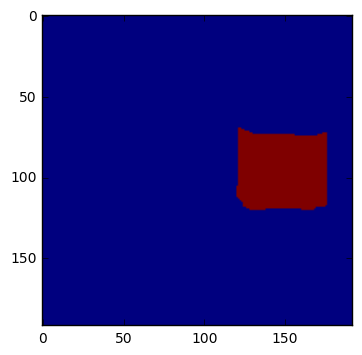

In [48]:
plt.imshow(roi_obj)

In [56]:
roi_obj.shape

(192, 192)